# Kilometer-scale flow-over-orography tests

Here we demostrate a few idealized tests used to demonstrate the ability of a solver to replicate flow over topography on kilometer scales. These tests are excellent for demonstrating that the nonhydrostatic dynamics works correctly, and also to show that the 

1) Schar mountain wave, to show proper vertical propagation of a wave of longer vertical dimension, and proper *non*-propagation of the shorter mountain waves.
2) Resting flow below a jet, to isolate errors from the hybridization and pressure-gradient force.

These are 2D (x-z) tests which use a five-point wide domain in the y-direction; the flow is very nearly homogeneous in the y-direction. **Note** that FV3 is a *fully-compressible* model and should not be expected to reproduce Boussinesq solutions. In particular gravity waves will increase in amplitude with height in FV3, which is especially pronounced in these mountain wave tests that often prescribe domains with tops at 30 km or higher. In particular tests that rely on precise amplitudes of mountain waves against a Bousinessq exact solution are inappropriate for any fully-compressible solver.

Since FV3 uses hybrid-pressure coordinates it is a little tricky to set up the initial state given in terms of height coordinates and buoyancy frequencies. See the notebook MountainWaveIC to see how this is done. 

Note that the "origak" run uses the 51 level setup with the same discontinuities that gave us trouble over topography in the auto-produced constant dz coordinate.

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import cartopy.crs as ccrs
import colorsys
import dask #Chunking will be necessary for the larger datasets

In [2]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (14, 6),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

In [3]:
ds0=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_1k.solo.mtn_rest_shear/history/0000000000/atmos_hourly.nc",decode_times=False)
ds0_stat=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_1k.solo.mtn_rest_shear/history/0000000000/atmos_static.nc",decode_times=False)

ds_olddamp=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_1k.solo.mtn_rest_shear.olddamp/history/0000000000/atmos_hourly.nc",decode_times=False)
ds_olddamp_stat=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_1k.solo.mtn_rest_shear.olddamp/history/0000000000/atmos_static.nc",decode_times=False)

cint=0.01

In [4]:
#A convenient routine.
def plot_topo_z(ax,xx,zs):
    zs2=np.append(zs,[0,0])
    c2 = np.append(xx,[xx[-1],xx[0]])
    ax.fill(c2,zs2,'black')
    #ax.fill(c2,zs2,'darkslategray')

## Schar mountain waves

Standard Mountain wave case of [Schar et al. (2002, MWR)](https://doi.org/10.1175/1520-0493(2002)130%3C2459:ANTFVC%3E2.0.CO;2) at 1-km and 500-m resolution to demonstrate convergence. We use a pre-defined 40-level setup from FV3 with a top at 50 mb (about 18 km), with Rayleigh damping applied above 250 mb that uses the usual arctangent profile in FV3. (FV3 is not set up to use the very strong and very thick wave-absorbing layers that mountain wave idealized tests use.)

Note that the vertically-propagating wave is very well-represented and the short-wavelength waves are properly evanescent (ie. decaying with height). This test is very similar to one done in Phase I of NGGPS; FV3 surprised a lot of people by doing very well at it.

<ipython-input-5-f55b1da407f2>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)


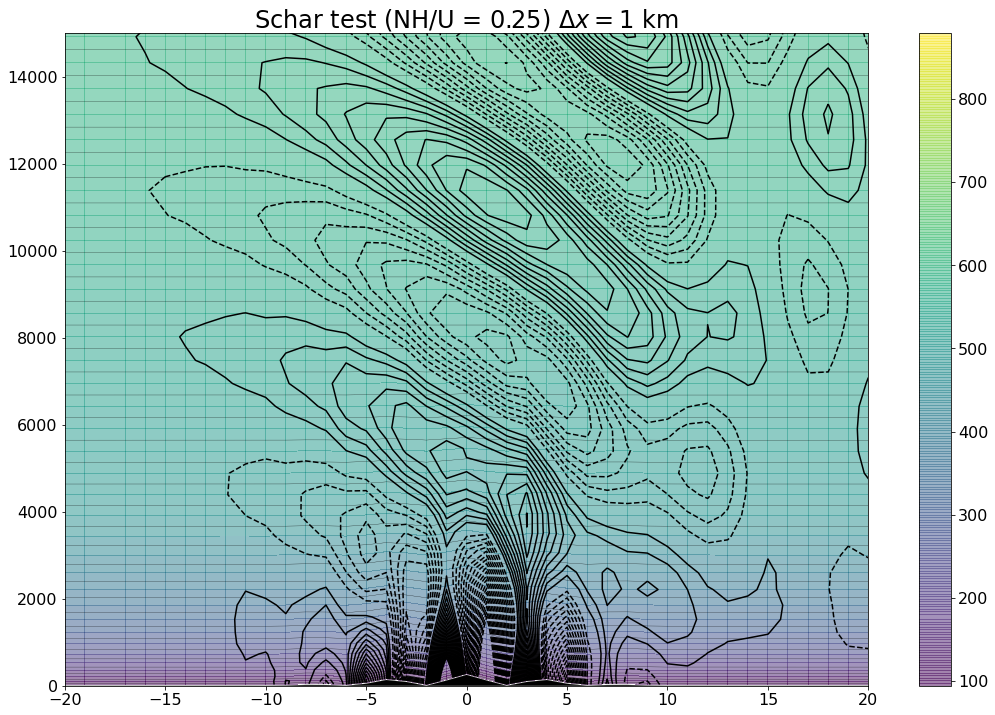

In [5]:
dsmtn=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_1k.solo.mtn_schar/history/0000000000/atmos_hourly.nc",decode_times=False)
dsmtn_stat=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_1k.solo.mtn_schar/history/0000000000/atmos_static.nc",decode_times=False)

ds=dsmtn.sel(grid_yt=1,time=5.0)

delp=ds.delp.values
w=ds.w.values
z=ds.hght.values
delz=ds.delz.values

x1d=ds.grid_xt.values - 96
x=np.tile(x1d,(w.shape[0],1))

zs=dsmtn_stat.sel(grid_yt=1).zsurf.values

#Compute interface z 
(Nz,Nx) = w.shape
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)


fig=plt.figure(figsize=(18,12))
#plt.contourf(x,z,w,levels=np.arange(-0.1,0.1,0.01),extend="both",cmap="RdBu_r")
plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)
plt.colorbar()
plt.contour(x,z,w,levels=np.arange(-1.0,0,0.05),colors="k",linestyles="--")
plt.contour(x,z,w,levels=np.arange(0.05,1.1,0.05),colors="k")
plot_topo_z(plt.gca(),x1d,zs)
plt.plot(x1d,zi.T,linewidth=0.25,color='k')

plt.gca().set_ylim((0,15000))
plt.gca().set_xlim((-20,20))
plt.gca().set_title("Schar test (NH/U = 0.25) $\Delta x = 1$ km")

x1km=x
z1km=z
w1km=w
#plt.gca().set_ylabel("Height [m]")
#plt.gca().set_title("Hour 5 vertical velocity with larger damping (CI=%.3f m/s) and delz [m]" % cint);

<ipython-input-6-2a4fa9cd298b>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)


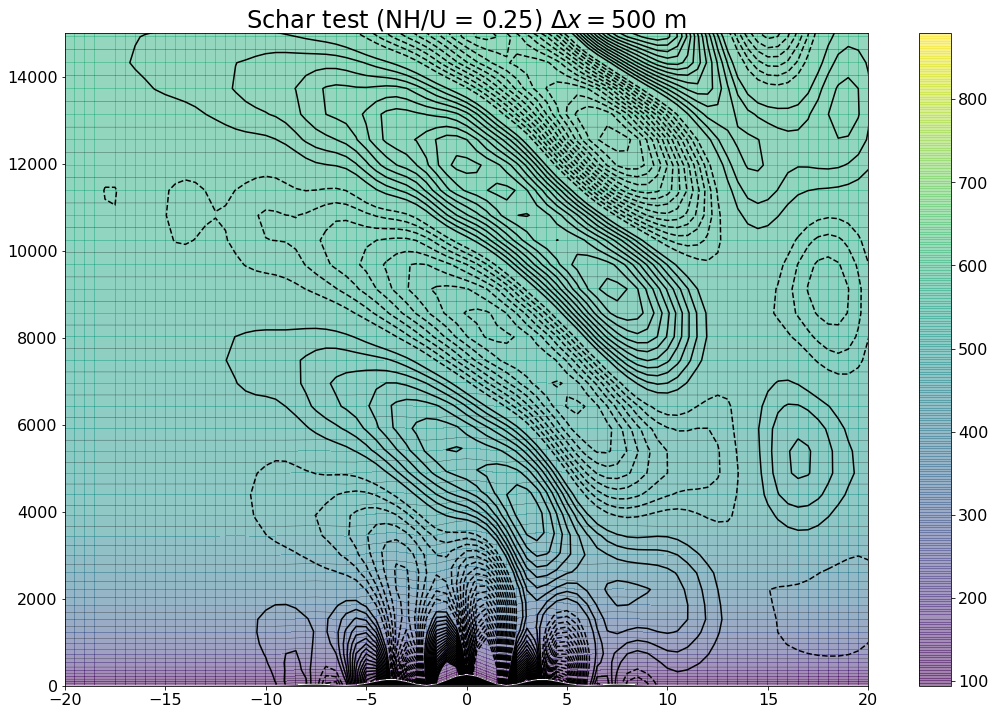

In [6]:
dsmtn=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_500m.solo.mtn_schar/history/0000000000/atmos_hourly.nc",decode_times=False)
dsmtn_stat=xa.open_dataset("/archive/lmh/SHiELD/202103/d96_500m.solo.mtn_schar/history/0000000000/atmos_static.nc",decode_times=False)

ds=dsmtn.sel(grid_yt=1,time=5.0)

delp=ds.delp.values
w=ds.w.values
z=ds.hght.values
delz=ds.delz.values

x1d=ds.grid_xt.values*0.5 - 96 #500 m
x=np.tile(x1d,(w.shape[0],1))

zs=dsmtn_stat.sel(grid_yt=1).zsurf.values

#Compute interface z 
(Nz,Nx) = w.shape
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)


fig=plt.figure(figsize=(18,12))
#plt.contourf(x,z,w,levels=np.arange(-0.1,0.1,0.01),extend="both",cmap="RdBu_r")
plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)
plt.colorbar()
plt.contour(x,z,w,levels=np.arange(-1.0,0,0.05),colors="k",linestyles="--")
plt.contour(x,z,w,levels=np.arange(0.05,1.1,0.05),colors="k")
plot_topo_z(plt.gca(),x1d,zs)
plt.plot(x1d,zi.T,linewidth=0.25,color='k')

#plt.contour(x1km,z1km,w1km,levels=np.arange(-1.0,0,0.05),colors="r",linestyles="--")
#plt.contour(x1km,z1km,w1km,levels=np.arange(0.05,1.1,0.05),colors="r")

plt.gca().set_ylim((0,15000))
plt.gca().set_xlim((-20,20))
plt.gca().set_title("Schar test (NH/U = 0.25) $\Delta x = 500$ m");


## Resting flow test

This uses a variant of the test of S-H Park et al (MWR, 2019). Here, the atmosphere above a small-scale mountain ridge is at rest until 10 km AGL, where a jet linearly ramps up to 20 m/s at 14 km AGL and is uniform above; and in which the atmosphere uses a uniform buoyancy frequency of 0.01 below 10 km and a more stable layer of 0.02 above. This atmosphere filters out errors in the lower troposphere (which would appear in the above Schar test or in the uniform atmosphere of the mtn_rest_100km test) to isolate errors due to the transition between hybrid and pure-pressure coordinates. 

We use a higher level for the jet in line with the hybridization used in most global models, which require placing the level at which the pure-pressure coordinate begins at about 100--300 mb, higher than in many mesoscale models. We also use the same 50 vertical level setup already existent within FV3.

This test emphasizes errors due to PGF errors in the upper troposphere (within the shear layer); the lower buoyancy frequency at lower layers reduces the vertical propagation of errors due to the PGF there. We find (again) that these are small, but can be enhanced due to a mis-configuration of the solver. 


<ipython-input-7-673c69eb26c1>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)


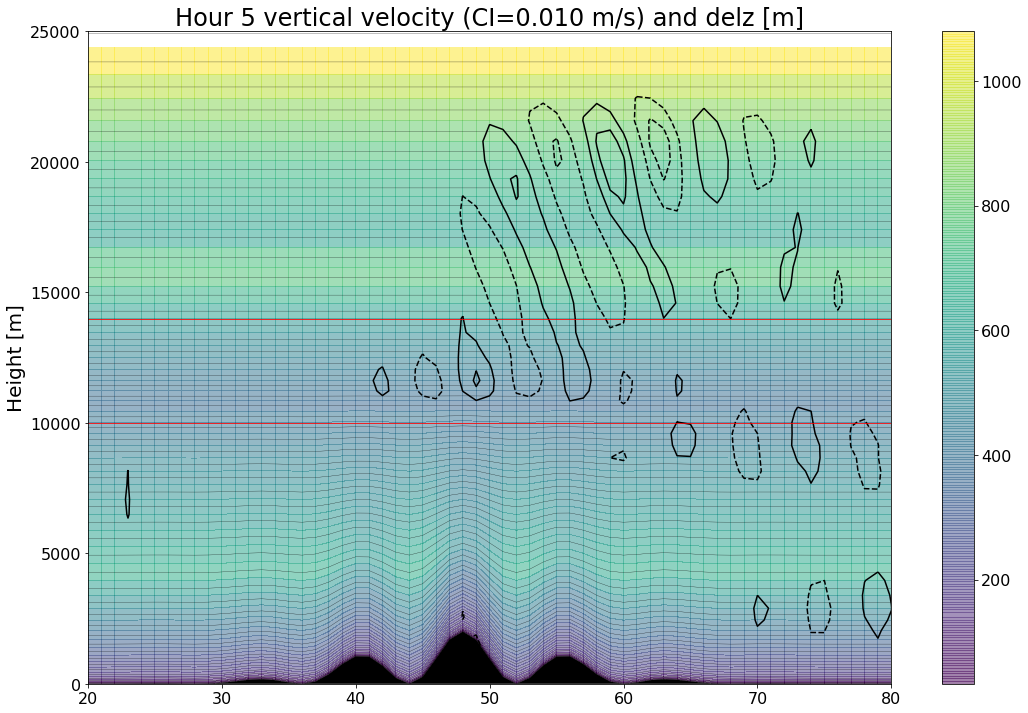

In [7]:
ds=ds0.sel(grid_yt=1,time=5.0)


delp=ds.delp.values
w=ds.w.values
z=ds.hght.values
delz=ds.delz.values

x1d=ds.grid_xt.values
x=np.tile(x1d,(w.shape[0],1))

zs=ds0_stat.sel(grid_yt=1).zsurf.values

#Compute interface z 
(Nz,Nx) = w.shape
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)


fig=plt.figure(figsize=(18,12))
plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)
plt.colorbar()
plt.contour(x,z,w,levels=np.arange(-1.0,0,cint),colors="k",linestyles="--")
plt.contour(x,z,w,levels=np.arange(cint,1.1,cint),colors="k")
plot_topo_z(plt.gca(),x1d,zs)
plt.plot(x1d,zi.T,linewidth=0.25,color='k')
plt.plot(x1d[[0,Nx-1]],[14000,14000],linewidth=0.8,color='r')
plt.plot(x1d[[0,Nx-1]],[10000,10000],linewidth=0.8,color='r')

plt.gca().set_ylim((0,25000))
plt.gca().set_xlim((20,80))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Hour 5 vertical velocity (CI=%.3f m/s) and delz [m]" % cint);

The above simulation used the C-SHiELD damping (eighth-order divergence damping, 0.03 vorticity damping coefficient, dissipative heating, etc.). One might think that adding more diffusion would damp the already very-low errors. The simulation below uses sixth-order divergence damping and stronger vorticity damping (0.06). The errors become substantially worse, especially near the surface in which there should not be any error at all. This is an example in which *less* damping gives a *better* result!

Note that this result differs from that in the 100-km test in which there was little to no sensitivity to diffusivity. This demonstrates that what works (or has no effect) at one resolution may have profound impacts at a different spatial scale. This also speaks to the strength of FV3 in that it can be configured to give great results at **any resolution**. (This also shows how one can fool themselves through idealized testing at one resolution and assume it applies to all resolutions---or how misconfiguring these tests can make a fool of the configurer.)

<ipython-input-8-58e89574252d>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)


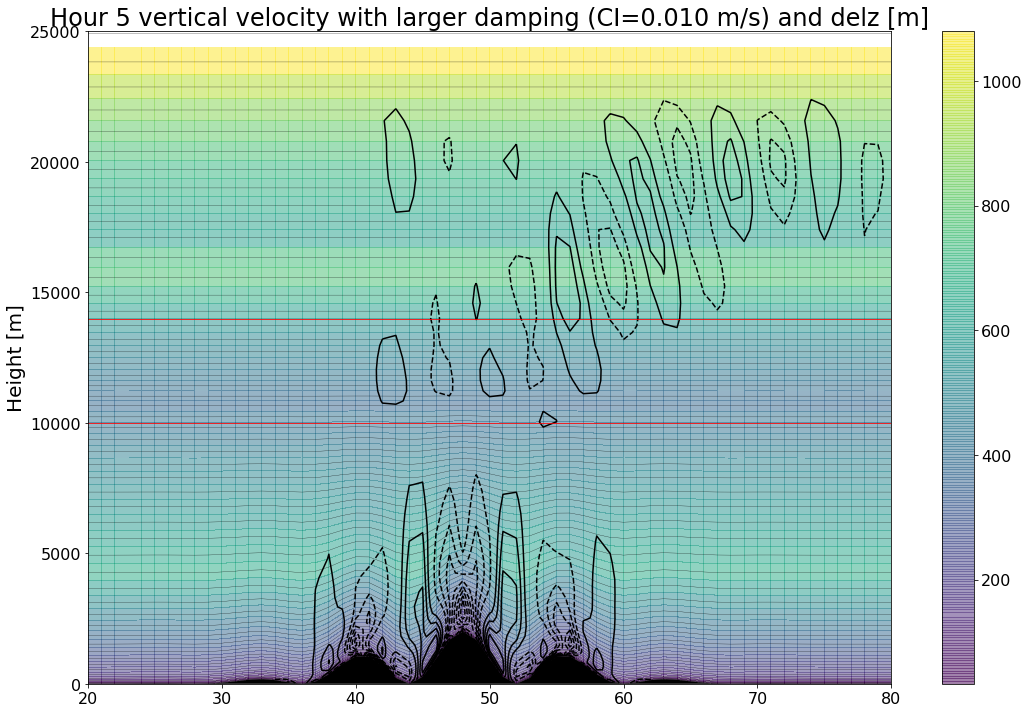

In [8]:
ds=ds_olddamp.sel(grid_yt=1,time=5.0)


delp=ds.delp.values
w=ds.w.values
z=ds.hght.values
delz=ds.delz.values

x1d=ds.grid_xt.values
x=np.tile(x1d,(w.shape[0],1))

zs=ds0_stat.sel(grid_yt=1).zsurf.values

#Compute interface z 
(Nz,Nx) = w.shape
zi = np.zeros((Nz+1,Nx)) + zs
zi[:-1,:] = zi[:-1,:] + np.flip(np.cumsum(np.flip(delz,axis=0),axis=0),axis=0)


fig=plt.figure(figsize=(18,12))
#plt.contourf(x,z,w,levels=np.arange(-0.1,0.1,0.01),extend="both",cmap="RdBu_r")
plt.pcolormesh(x,z,delz,alpha=0.5,edgecolor=None,)
plt.colorbar()
plt.contour(x,z,w,levels=np.arange(-1.0,0,cint),colors="k",linestyles="--")
plt.contour(x,z,w,levels=np.arange(cint,1.1,cint),colors="k")
plot_topo_z(plt.gca(),x1d,zs)
plt.plot(x1d,zi.T,linewidth=0.25,color='k')
plt.plot(x1d[[0,Nx-1]],[14000,14000],linewidth=0.8,color='r')
plt.plot(x1d[[0,Nx-1]],[10000,10000],linewidth=0.8,color='r')

plt.gca().set_ylim((0,25000))
plt.gca().set_xlim((20,80))
plt.gca().set_ylabel("Height [m]")
plt.gca().set_title("Hour 5 vertical velocity with larger damping (CI=%.3f m/s) and delz [m]" % cint);